# Project Optimization for Machine Learning 

Maxence Lasbordes | M2 MASH

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

## Question 1

For this project we will use the a9a dataset. This dataset is a binary classification problem with sparse features. The goal is to predict whether an individual makes over 50K a year based on the features provided. The dataset is available at the following URL: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a

In [78]:
with open('a9a.txt', 'r') as file:
    lines = file.readlines()

labels = []
features = []

for line in lines:
    parts = line.strip().split()
    
    labels.append(int(parts[0]))
    
    feature_dict = {}
    for feat in parts[1:]:
        index, value = feat.split(':')
        feature_dict[int(index)] = float(value)
    
    features.append(feature_dict)

The dataset contains 32561 samples and 123 features. The features are very sparse. We are only focusing on the training set which contains 32561 samples.

In [79]:
print('Number of samples:', len(labels))
print('Number of features:', len(features[0]))
print(labels[:5])
print(features[:5])

Number of samples: 32561
Number of features: 14
[-1, -1, -1, -1, -1]
[{3: 1.0, 11: 1.0, 14: 1.0, 19: 1.0, 39: 1.0, 42: 1.0, 55: 1.0, 64: 1.0, 67: 1.0, 73: 1.0, 75: 1.0, 76: 1.0, 80: 1.0, 83: 1.0}, {5: 1.0, 7: 1.0, 14: 1.0, 19: 1.0, 39: 1.0, 40: 1.0, 51: 1.0, 63: 1.0, 67: 1.0, 73: 1.0, 74: 1.0, 76: 1.0, 78: 1.0, 83: 1.0}, {3: 1.0, 6: 1.0, 17: 1.0, 22: 1.0, 36: 1.0, 41: 1.0, 53: 1.0, 64: 1.0, 67: 1.0, 73: 1.0, 74: 1.0, 76: 1.0, 80: 1.0, 83: 1.0}, {5: 1.0, 6: 1.0, 17: 1.0, 21: 1.0, 35: 1.0, 40: 1.0, 53: 1.0, 63: 1.0, 71: 1.0, 73: 1.0, 74: 1.0, 76: 1.0, 80: 1.0, 83: 1.0}, {2: 1.0, 6: 1.0, 18: 1.0, 19: 1.0, 39: 1.0, 40: 1.0, 52: 1.0, 61: 1.0, 71: 1.0, 72: 1.0, 74: 1.0, 76: 1.0, 80: 1.0, 95: 1.0}]


We can see that the dataset is in a sparse format. Only the non-zero features are specified.

In [80]:
max_index = max([max(feat.keys()) for feat in features if feat])
dense_features = np.zeros((len(features), max_index))

# The features are 1-indexed so we shift them to 0-indexed
for i, feat in enumerate(features):
    for index, value in feat.items():
        dense_features[i, index-1] = value
print(dense_features[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


We now have the full dense matrix, so we can generate the correlation matrix.

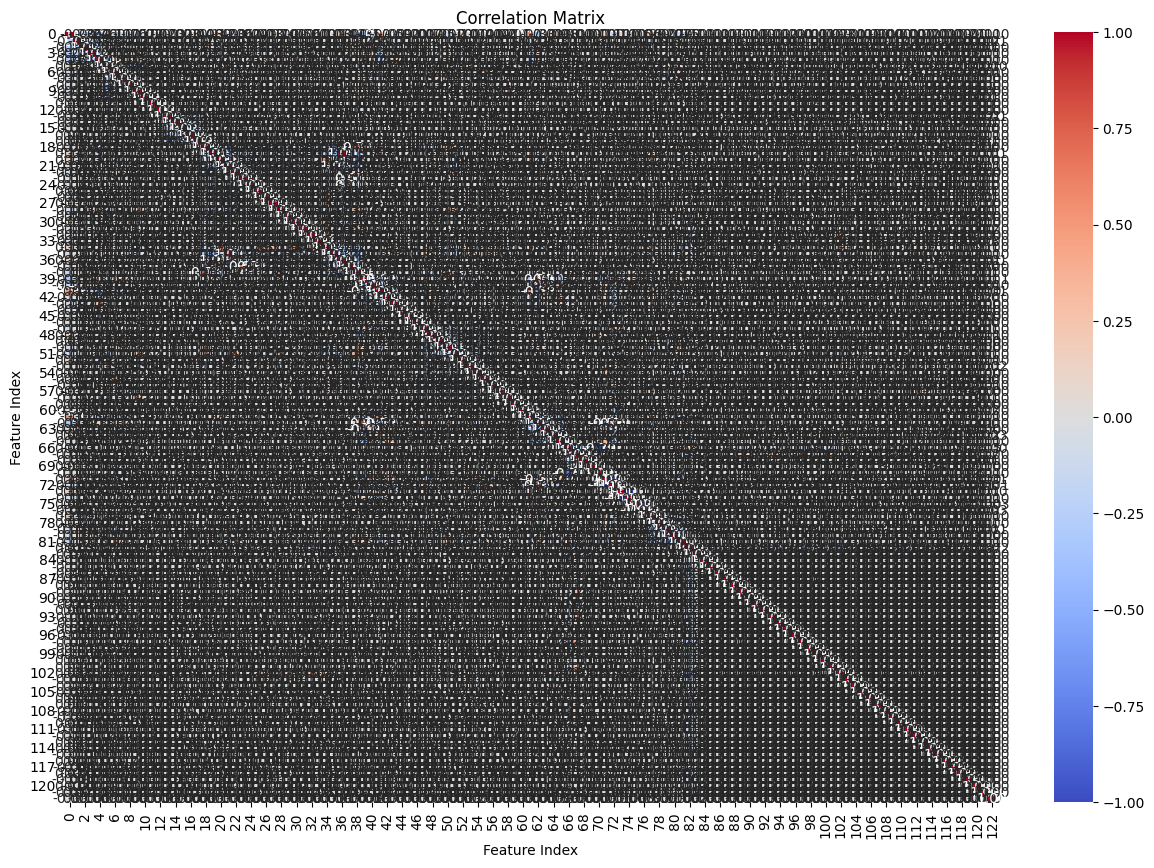

In [81]:
dataframe = pd.DataFrame(dense_features)
correlation_matrix = dataframe.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.xlabel("Feature Index")
plt.ylabel("Feature Index")
plt.show()


Because of the huge number of features (123), it is very hard to visualize correctly the correlation matrix.

## Qestion 2

We will build the f function and the gradient of the f function.

In [82]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def f_i(x, a_i, y_i):
    return (y_i - sigmoid(torch.dot(a_i, x))) ** 2

def grad_f_i_explicit(x, a_i, y_i):
    exp_term = torch.exp(torch.dot(a_i, x))
    numerator = 2 * exp_term * (exp_term * (y_i - 1) + y_i)
    denominator = (1 + exp_term) ** 3
    return - (numerator / denominator) * a_i

We will now compare the explicit computation of the gradient with the gradient from the automatic differentiation.

In [83]:
a_i = torch.tensor(dense_features[0], dtype=torch.float32)
y_i = torch.tensor(labels[0], dtype=torch.float32)
x = torch.randn(a_i.size(0), requires_grad=True)


f_value = f_i(x, a_i, y_i)
f_value.backward() # Compute the gradients
grad_f_i_autograd = x.grad # Get the gradients
grad_f_i_explicit = grad_f_i_explicit(x, a_i, y_i)

print("Autograd gradient:", grad_f_i_autograd)
print("Explicit gradient:", grad_f_i_explicit)

# We check if the gradients match with a small tollerance
if torch.allclose(grad_f_i_autograd, grad_f_i_explicit):
    print("\nValidation: Gradients match !!!")
else:
    print("\nValidation: Gradients do not match !!!")

Autograd gradient: tensor([0.0000, 0.0000, 0.0364, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0364, 0.0000, 0.0000, 0.0364, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0364, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0364, 0.0000, 0.0000, 0.0364, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0364, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0364, 0.0000, 0.0000, 0.0364, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0364, 0.0000, 0.0364, 0.0364, 0.0000, 0.0000, 0.0000, 0.0364, 0.0000,
        0.0000, 0.0364, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.000

As expected, the gradients are indeed matching !

## Question 3

Implementation of gradient descent for our problem. We reused a part of the code from the Lab 2.

In [84]:
def f(x, A, y):
    sigmoid = 1 / (1 + torch.exp(-A @ x))
    return torch.mean((y - sigmoid) ** 2)

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Let's test the function with a small subset of 1000 data points to make it faster
A = torch.tensor(dense_features[:1000], dtype=torch.float32, device=device)
y = torch.tensor(labels[:1000], dtype=torch.float32, device=device)
x = torch.randn(A.size(1), requires_grad=True, device=device)

Step size 3, Iteration 0/100 : Loss : 2.186828851699829
Step size 3, Iteration 10/100 : Loss : 1.0111451148986816
Step size 3, Iteration 20/100 : Loss : 1.0033867359161377
Step size 3, Iteration 30/100 : Loss : 1.001236081123352
Step size 3, Iteration 40/100 : Loss : 1.0003330707550049
Step size 3, Iteration 50/100 : Loss : 0.9998317956924438
Step size 3, Iteration 60/100 : Loss : 0.9994914531707764
Step size 3, Iteration 70/100 : Loss : 0.9992251396179199
Step size 3, Iteration 80/100 : Loss : 0.9989950656890869
Step size 3, Iteration 90/100 : Loss : 0.998782217502594
Step size 2.5, Iteration 0/100 : Loss : 2.780731439590454
Step size 2.5, Iteration 10/100 : Loss : 1.013646125793457
Step size 2.5, Iteration 20/100 : Loss : 1.004689335823059
Step size 2.5, Iteration 30/100 : Loss : 1.0026336908340454
Step size 2.5, Iteration 40/100 : Loss : 1.0017834901809692
Step size 2.5, Iteration 50/100 : Loss : 1.001328468322754
Step size 2.5, Iteration 60/100 : Loss : 1.0010470151901245
Step size

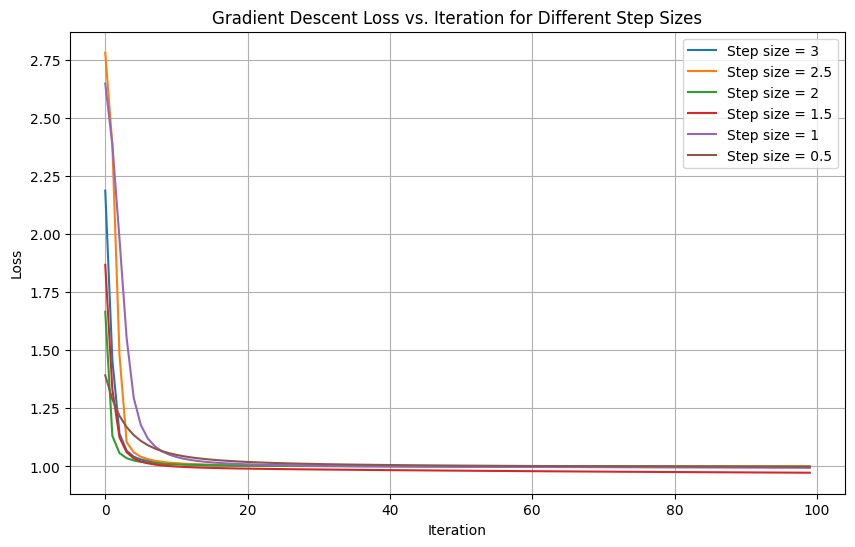

In [86]:
nb_iters = 100
step_sizes = [3, 2.5, 2, 1.5, 1, 0.5]

losses_dict = {stepsize: [] for stepsize in step_sizes}

for stepsize in step_sizes:
    x = torch.randn(A.size(1), requires_grad=True, device=device)
    for i in range(nb_iters):
        loss = f(x, A, y)
        loss.backward()
        with torch.no_grad():
            x -= stepsize*x.grad
            x.grad.zero_()

        losses_dict[stepsize].append(loss.detach().item())
        
        if i % 10 == 0:
            print(f"Step size {stepsize}, Iteration {i}/{nb_iters} : Loss : {loss.item()}")

# Plot the losses for each step size
plt.figure(figsize=(10, 6))
for stepsize, losses in losses_dict.items():
    plt.plot(range(nb_iters ), losses, label=f"Step size = {stepsize}")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Gradient Descent Loss vs. Iteration for Different Step Sizes")
plt.legend()
plt.grid()
plt.show()

- The expected gradient descent convergence rate for **non-convex functions** is $O\left(\frac{1}{\sqrt{k}}\right)$, where $k$ is the number of iterations. And we can observe this convergence rate empirically on the previous plot for the 1.5 step size.
- Since it is a non convexe optimization problem we don't have a defined best constant stepsize, but experimentally I found that a good constant stepsize seems to be around 1.5.

## Question 4

Implementation of the Batch Stochastic Gradient Descent with various constant step sizes.

Step size 3, Iteration 0/100 : Loss : 1.2649269065856934
Step size 3, Iteration 10/100 : Loss : 1.0134881896972656
Step size 3, Iteration 20/100 : Loss : 0.975144058227539
Step size 3, Iteration 30/100 : Loss : 0.9683539619445801
Step size 3, Iteration 40/100 : Loss : 0.9608267745971679
Step size 3, Iteration 50/100 : Loss : 0.9551635475158692
Step size 3, Iteration 60/100 : Loss : 0.9518445014953614
Step size 3, Iteration 70/100 : Loss : 0.9516175842285156
Step size 3, Iteration 80/100 : Loss : 0.9494062309265137
Step size 3, Iteration 90/100 : Loss : 0.9496779556274414
Step size 2.5, Iteration 0/100 : Loss : 1.0578110122680664
Step size 2.5, Iteration 10/100 : Loss : 1.0240807609558105
Step size 2.5, Iteration 20/100 : Loss : 1.0229849815368652
Step size 2.5, Iteration 30/100 : Loss : 0.9830973434448242
Step size 2.5, Iteration 40/100 : Loss : 0.9703367347717285
Step size 2.5, Iteration 50/100 : Loss : 0.9628512611389161
Step size 2.5, Iteration 60/100 : Loss : 0.957918155670166
Step

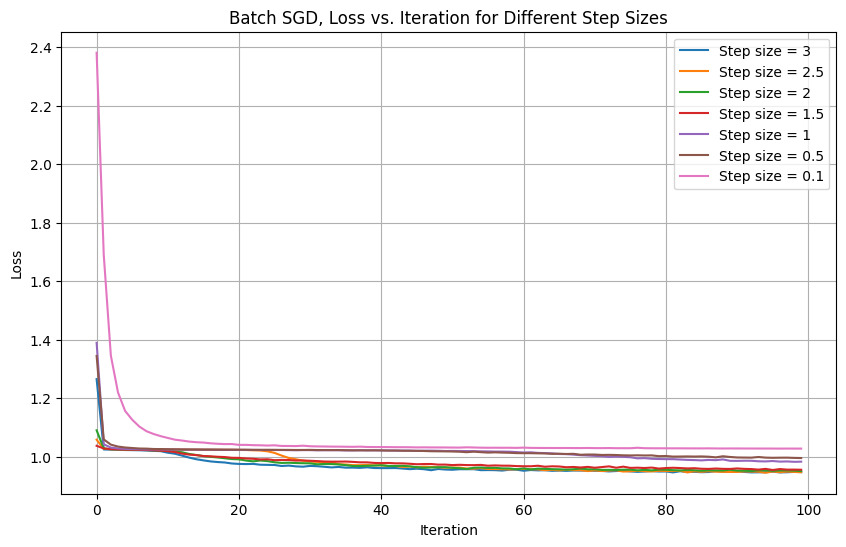

In [ ]:
# Batch SGD

batch_size = 64
nb_iters = 100
step_sizes = [3, 2.5, 2, 1.5, 1, 0.5, 0.1]

losses_dict = {stepsize: [] for stepsize in step_sizes}

for stepsize in step_sizes:
    x = torch.randn(A.size(1), requires_grad=True, device=device)
    for i in range(nb_iters):
        # Shuffle data
        indices = torch.randperm(A.size(0))
        A_shuffled = A[indices]
        y_shuffled = y[indices]
        
        total_loss = 0
        for b in range(0, A.size(0), batch_size):
            
            A_batch = A_shuffled[b:b+batch_size]
            y_batch = y_shuffled[b:b+batch_size]
            
            loss = f(x, A_batch, y_batch)
            total_loss += loss.item()
            loss.backward()
        
            with torch.no_grad():
                x -= stepsize * x.grad
                x.grad.zero_()
        
        # Average loss over all batches
        avg_loss = total_loss / (A.size(0) / batch_size)
        losses_dict[stepsize].append(avg_loss)
        
        if i % 10 == 0:
            print(f"Step size {stepsize}, Iteration {i}/{nb_iters} : Loss : {avg_loss}")
            
# Plot the losses for each step size
plt.figure(figsize=(10, 6))
for stepsize, losses in losses_dict.items():
    plt.plot(range(nb_iters ), losses, label=f"Step size = {stepsize}")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Batch SGD, Loss vs. Iteration for Different Step Sizes")
plt.legend()
plt.grid()
plt.show()

- In theory, Batch SGD has faster convergence per epoch because we update each parameter multiple times. The results confirm this theory, as the loss evolution is more consistent and lower after 100 epochs for the best constant step sizes (around 2.5).
- The best constant step size seems to be around 2.5 and the best batch size for this step size is 16, as we can see in the next graph computed.

Batch size 16, Epochs 0/100 : Loss : 1.0188475141525268
Batch size 16, Epochs 1/100 : Loss : 1.0075865840911866
Batch size 16, Epochs 2/100 : Loss : 1.006454257965088
Batch size 16, Epochs 3/100 : Loss : 0.997158332824707
Batch size 16, Epochs 4/100 : Loss : 0.9827456626892089
Batch size 16, Epochs 5/100 : Loss : 0.9724474220275879
Batch size 16, Epochs 6/100 : Loss : 0.9666523160934448
Batch size 16, Epochs 7/100 : Loss : 0.9623333139419555
Batch size 16, Epochs 8/100 : Loss : 0.9570609474182129
Batch size 16, Epochs 9/100 : Loss : 0.9566926946640014
Batch size 16, Epochs 10/100 : Loss : 0.956782205581665
Batch size 16, Epochs 11/100 : Loss : 0.9513599920272827
Batch size 16, Epochs 12/100 : Loss : 0.9472079372406006
Batch size 16, Epochs 13/100 : Loss : 0.945741093635559
Batch size 16, Epochs 14/100 : Loss : 0.9433106193542481
Batch size 16, Epochs 15/100 : Loss : 0.943521255493164
Batch size 16, Epochs 16/100 : Loss : 0.9467741546630859
Batch size 16, Epochs 17/100 : Loss : 0.941794

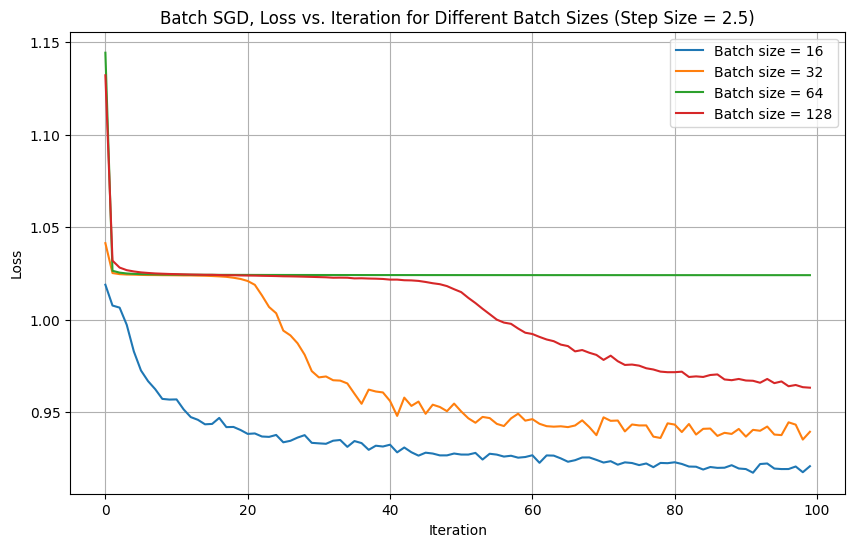

In [227]:
# Batch SGD

batch_sizes = [16, 32, 64, 128]  # Test these batch sizes
step_size = 2.5  # Since we found it was the best step size
epochs = 100  # Number of iterations

losses_dict = {batch_size: [] for batch_size in batch_sizes}

# Batch SGD with constant step size
for batch_size in batch_sizes:
    x = torch.randn(A.size(1), requires_grad=True, device=device)
    for epoch in range(epochs):
        # Shuffle data
        indices = torch.randperm(A.size(0))
        A_shuffled = A[indices]
        y_shuffled = y[indices]
        
        total_loss = 0
        for b in range(0, A.size(0), batch_size):
            A_batch = A_shuffled[b:b+batch_size]
            y_batch = y_shuffled[b:b+batch_size]
            
            loss = f(x, A_batch, y_batch)
            total_loss += loss.item()
            
            loss.backward()

            with torch.no_grad():
                x -= step_size * x.grad
                x.grad.zero_()
        
        # Average loss over all batches
        avg_loss = total_loss / (A.size(0) / batch_size)
        losses_dict[batch_size].append(avg_loss)
        
        print(f"Batch size {batch_size}, Epochs {epoch}/{epochs} : Loss : {avg_loss}")

# Plot the losses for each batch size
plt.figure(figsize=(10, 6))
for batch_size, losses in losses_dict.items():
    plt.plot(range(nb_iters), losses, label=f"Batch size = {batch_size}")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(f"Batch SGD, Loss vs. Iteration for Different Batch Sizes (Step Size = {step_size})")
plt.legend()
plt.grid()
plt.show()

## Question 5

We will now implement Adagrad and compare it with the best result from Batch SGD with batch size of 16 and a learning rate of 2.5.

Adagrad, Iteration 0/100 : Loss : 1.0037726936340332
Adagrad, Iteration 10/100 : Loss : 0.9332298784255981
Adagrad, Iteration 20/100 : Loss : 0.9258254203796387
Adagrad, Iteration 30/100 : Loss : 0.9217158479690551
Adagrad, Iteration 40/100 : Loss : 0.9191737432479858
Adagrad, Iteration 50/100 : Loss : 0.9170286235809326
Adagrad, Iteration 60/100 : Loss : 0.9149073829650879
Adagrad, Iteration 70/100 : Loss : 0.9150953741073609
Adagrad, Iteration 80/100 : Loss : 0.9155781621932984
Adagrad, Iteration 90/100 : Loss : 0.9143404111862182


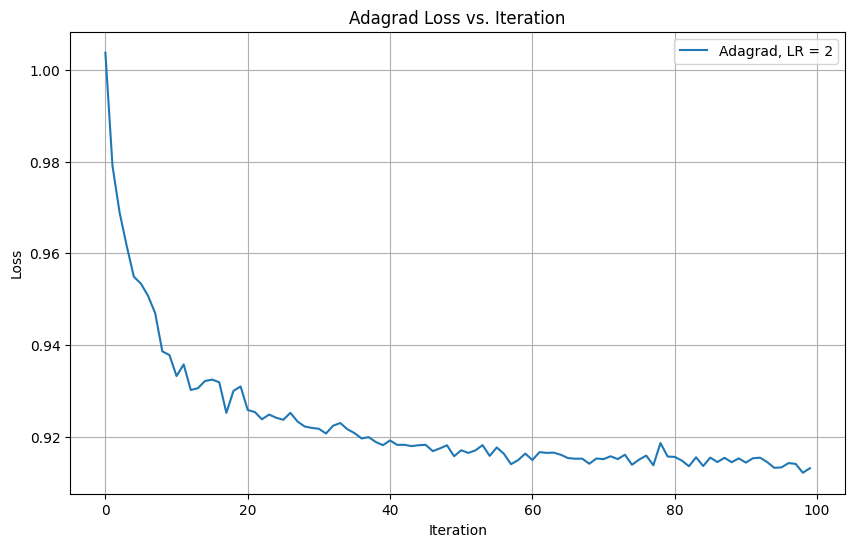

In [142]:
# Adagrad implementation

batch_size = 16
nb_iters = 100
lr = 2
epsilon = 1e-8

x = torch.randn(A.size(1), requires_grad=True, device=device)
G = torch.zeros_like(x, device=device)
adagrad_losses = []
for i in range(nb_iters):
    indices = torch.randperm(A.size(0))
    A_shuffled = A[indices]
    y_shuffled = y[indices]
    total_loss = 0
    for b in range(0, A.size(0), batch_size):
        A_batch = A_shuffled[b:b+batch_size]
        y_batch = y_shuffled[b:b+batch_size]
        loss = f(x, A_batch, y_batch)
        total_loss += loss.item()
        loss.backward()
        G.add_(x.grad.pow(2))
        with torch.no_grad():
            x -= lr / torch.sqrt(G + epsilon) * x.grad
            x.grad.zero_()
    avg_loss = total_loss / (A.size(0) / batch_size)
    adagrad_losses.append(avg_loss)
    if i % 10 == 0:
        print(f"Adagrad, Iteration {i}/{nb_iters} : Loss : {avg_loss}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(nb_iters), adagrad_losses, label=f"Adagrad, LR = {lr}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Adagrad Loss vs. Iteration")
plt.legend()
plt.grid()
plt.show()

- As expected, the results are slighly better with Adagrad compared to the Batch SGD for the same configuration, but the training is much faster with batch SGD.

## Question 6

We will now implement the proximal gradient approach with the regularized version of the problem. We take 100 iterations and a step size of 2.5 based on previous experiments.

Lambda 0.001, Iteration 0/100 : Total Loss : 2.7937822341918945
Lambda 0.001, Iteration 10/100 : Total Loss : 1.1132606267929077
Lambda 0.001, Iteration 20/100 : Total Loss : 1.1026146411895752
Lambda 0.001, Iteration 30/100 : Total Loss : 1.097569227218628
Lambda 0.001, Iteration 40/100 : Total Loss : 1.0936344861984253
Lambda 0.001, Iteration 50/100 : Total Loss : 1.0902553796768188
Lambda 0.001, Iteration 60/100 : Total Loss : 1.0871518850326538
Lambda 0.001, Iteration 70/100 : Total Loss : 1.0842095613479614
Lambda 0.001, Iteration 80/100 : Total Loss : 1.081372618675232
Lambda 0.001, Iteration 90/100 : Total Loss : 1.0786681175231934
Lambda = 0.001: Sparsity = 17.07%
Lambda 0.01, Iteration 0/100 : Total Loss : 3.020785331726074
Lambda 0.01, Iteration 10/100 : Total Loss : 1.769435167312622
Lambda 0.01, Iteration 20/100 : Total Loss : 1.553912878036499
Lambda 0.01, Iteration 30/100 : Total Loss : 1.4077719449996948
Lambda 0.01, Iteration 40/100 : Total Loss : 1.2892885208129883
Lam

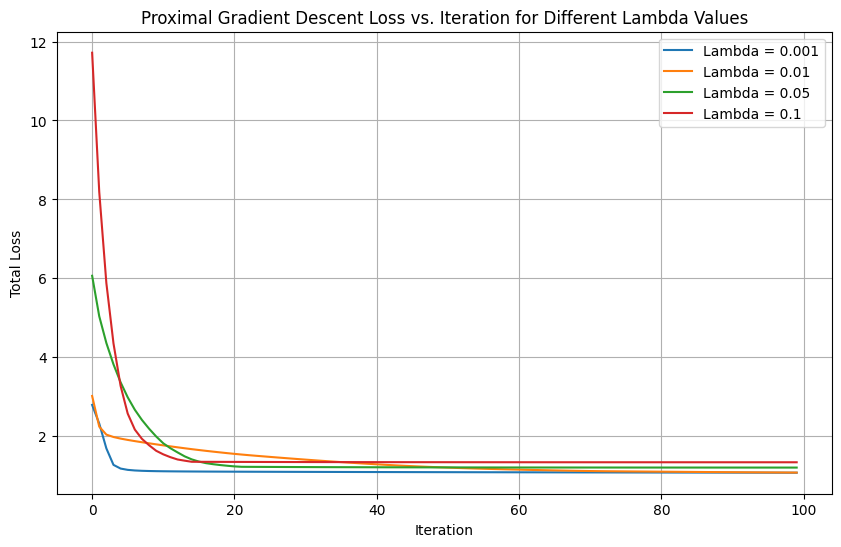

In [ ]:
# Proximal Gradient Descent for regularized problem

nb_iters = 100
step_size = 2.5
lambda_values = [0.001, 0.01, 0.05, 0.1]  # Test these lambda values

losses_dict = {lambdaa: [] for lambdaa in lambda_values}
sparsity_dict = {lambdaa: 0.0 for lambdaa in lambda_values}

for lambdaa in lambda_values:
    x = torch.randn(A.size(1), requires_grad=True, device=device)
    
    for i in range(nb_iters):
        loss = f(x, A, y)
        
        l1_term = lambdaa * torch.norm(x, p=1)
        total_loss = loss + l1_term
        
        loss.backward()

        with torch.no_grad():
            x_new = x - step_size * x.grad
            x_prox = torch.sign(x_new) * torch.clamp(torch.abs(x_new) - step_size * lambdaa, min=0.0)
            x.copy_(x_prox)
            x.grad.zero_()
        
        losses_dict[lambdaa].append(total_loss.item())
        
        if i % 10 == 0:
            print(f"Lambda {lambdaa}, Iteration {i}/{nb_iters} : Total Loss : {total_loss.item()}")

    sparsity = (x == 0).float().mean().item() * 100
    print(f"Lambda = {lambdaa}: Sparsity = {sparsity:.2f}%")

# Plotting the results
plt.figure(figsize=(10, 6))
for lambdaa, losses in losses_dict.items():
    plt.plot(range(nb_iters), losses, label=f"Lambda = {lambdaa}")

plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.title("Proximal Gradient Descent Loss vs. Iteration for Different Lambda Values")
plt.legend()
plt.grid()
plt.show()

- Lambda = 0.01 seems to be a good value for the regularization parameter as it yields a 91.87% of sparsity for the solution vector and the loss is still low.

## Question 7

Let's now implement the BFGS method and compare it with the regular gradient descent on the first problem. We reuse the variables name from the decription of the BFGS technique. We will use a constant step size of 0.1 and 100 iterations.

In [ ]:
# BFGS Method

nb_iters = 100
step_size = 0.01 # constant step size

x = torch.randn(A.size(1), device=device, requires_grad=True)
H = torch.eye(x.size(0), device=x.device)

for i in range(nb_iters):
    loss = f(x, A, y)
    loss.backward()
    g = x.grad.clone()
    x.grad.zero_()
    
    x_new = (x - step_size * torch.matmul(H, g)).detach().requires_grad_(True)
    f_new = f(x_new, A, y)
    f_new.backward()
    g_new = x_new.grad.clone()
    x_new.grad.zero_()
    
    s = x_new - x
    v = g_new - g
    dot_product = torch.dot(s, v)
    if dot_product > 0:
        rho = torch.outer(s, v)
        I = torch.eye(H.size(0), device=device)
        H = (I - rho / dot_product) @ H @ (I - rho / dot_product).T + torch.outer(s, s) / dot_product

    if i % 10 == 0 or i == nb_iters - 1:
        print(f"Iteration {i}/{nb_iters} : Loss : {loss.item()}")

    x = x_new.detach().requires_grad_(True)

Iteration 0/100 : Loss : 1.059018611907959
Iteration 10/100 : Loss : 1.0531277656555176
Iteration 20/100 : Loss : 1.0471994876861572
Iteration 30/100 : Loss : 1.0418123006820679
Iteration 40/100 : Loss : 1.0369892120361328
Iteration 50/100 : Loss : 1.032723307609558
Iteration 60/100 : Loss : 1.0289827585220337
Iteration 70/100 : Loss : 1.0257185697555542
Iteration 80/100 : Loss : 1.0228744745254517
Iteration 90/100 : Loss : 1.020393967628479
Iteration 99/100 : Loss : 1.018429160118103


- We observe very similar results between BFGS and the regular gradient descent. The loss is very similar. One thing to note is that the BFGS method is more computationally expensive than the regular gradient descent and we have nan values for the loss with bigger step sizes (I wasn't able to solve this problem).

## Question 8

We implement the stochastic gradient variant of the BFGS method. We will use a constant step size of 0.1 and 10 epochs since it is very computationally expensive (we use the explicit formular to compute the gradient this time).

In [92]:
def grad_f(x, A, y):
    exp_term = torch.exp(A @ x)
    numerator = 2 * exp_term * (exp_term * (y - 1) + y)
    denominator = (1 + exp_term) ** 3
    scalar_factors = - (numerator / denominator)
    return torch.mean(scalar_factors.unsqueeze(1) * A, dim=0)

In [ ]:
# BFGS Method with stochastic gradient

epochs = 100
step_size = 0.001  # constant step size
batch_size = 128

x = torch.randn(A.size(1), device=device, requires_grad=True)
H = torch.eye(A.size(1), device=device)
for epoch in range(epochs):
    indices = torch.randperm(A.size(0))
    A_shuffled = A[indices]
    y_shuffled = y[indices]
    total_loss = 0
    for b in range(0, A.size(0), batch_size):
        A_batch = A_shuffled[b:b+batch_size]
        y_batch = y_shuffled[b:b+batch_size]

        g = grad_f(x, A_batch, y_batch)
        loss = f(x, A_batch, y_batch)
        total_loss += loss.item()
        x_new = x - step_size * torch.matmul(H, g)
        g_new = grad_f(x_new, A_batch, y_batch)
        s = x_new - x
        v = g_new - g
        dot_product = torch.dot(s, v)
        
        if dot_product > 0:
            rho = torch.outer(s, v)
            I = torch.eye(H.size(0), device=device)
            H = (I - rho / dot_product) @ H @ (I - rho / dot_product).T + torch.outer(s, s) / dot_product

        x = x_new
    avg_loss = total_loss / (A.size(0) / batch_size)
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epochs {epoch}/{epochs} : Loss : {avg_loss}")

Epochs 0/100 : Loss : 2.4262610778808593
Epochs 10/100 : Loss : 1.2706128845214844
Epochs 20/100 : Loss : 1.2389833984375
Epochs 30/100 : Loss : 1.2041190795898438
Epochs 40/100 : Loss : 1.1746941375732423
Epochs 50/100 : Loss : 1.1399949493408204
Epochs 60/100 : Loss : 1.125844223022461
Epochs 70/100 : Loss : 1.1115374298095704
Epochs 80/100 : Loss : 1.1006154937744141
Epochs 90/100 : Loss : 1.090562286376953
Epochs 99/100 : Loss : 1.0829546661376954


## Question 9

Number of data access and vector updates for the BFGS Method.

In [ ]:
# BFGS Method

nb_iters = 100
step_size = 0.01 # constant step size

x = torch.randn(A.size(1), device=device, requires_grad=True)
H = torch.eye(x.size(0), device=x.device)

data_access = 0
vector_updates = 0

for i in range(nb_iters):
    loss = f(x, A, y)
    data_access += 1
    loss.backward()
    g = x.grad.clone()
    x.grad.zero_()
    
    x_new = (x - step_size * torch.matmul(H, g)).detach().requires_grad_(True)
    vector_updates += 1
    f_new = f(x_new, A, y)
    data_access += 1
    f_new.backward()
    g_new = x_new.grad.clone()
    x_new.grad.zero_()
    
    s = x_new - x
    v = g_new - g
    dot_product = torch.dot(s, v)
    if dot_product > 0:
        rho = torch.outer(s, v)
        I = torch.eye(H.size(0), device=device)
        H = (I - rho / dot_product) @ H @ (I - rho / dot_product).T + torch.outer(s, s) / dot_product

    x = x_new.detach().requires_grad_(True)

print("Data accesses:", data_access)
print("Vector updates:", vector_updates)

Data accesses: 200
Vector updates: 100


Number of data access and vector updates for the Adagrad Method.

In [229]:
# Adagrad implementation

batch_size = 16
nb_epochs = 100
lr = 2
epsilon = 1e-8

data_access = 0
vector_updates = 0

x = torch.randn(A.size(1), requires_grad=True, device=device)
G = torch.zeros_like(x, device=device)
adagrad_losses = []
for i in range(nb_epochs):
    indices = torch.randperm(A.size(0))
    A_shuffled = A[indices]
    y_shuffled = y[indices]
    total_loss = 0
    for b in range(0, A.size(0), batch_size):
        data_access += 1
        A_batch = A_shuffled[b:b+batch_size]
        y_batch = y_shuffled[b:b+batch_size]
        loss = f(x, A_batch, y_batch)
        total_loss += loss.item()
        loss.backward()
        G.add_(x.grad.pow(2))
        with torch.no_grad():
            x -= lr / torch.sqrt(G + epsilon) * x.grad
            vector_updates += 1
            x.grad.zero_()
    avg_loss = total_loss / (A.size(0) / batch_size)
    adagrad_losses.append(avg_loss)

print("Data accesses:", data_access)
print("Vector updates:", vector_updates)

Data accesses: 6300
Vector updates: 6300


- As we can see the amount of Data accesses and vector uppdates for the Adagrad Method with a batch size of 16 on 200 iterations is 6300 meanwhile for the BFGS method with 100 iterations it is 200 and 100 respectively. This is a huge difference in terms of computational cost and computational speed. The BFGS is much faster compared to the Adagrad method, but the adagrad method is more accurate and the loss is lower at the end.

- We therefore have 1 vector update per iteration (basically per batch update) but 63 per epoch.

## Question 10

We combine the proximal gradient implementation from question 6 with the BFGS technique on the regularized problem. Results are very similar to the proximal gradient descent, for a fixed value of lambda which is $0.001$ in our case. The loss is slightly lower for the Proximal Gradient approach of question 6 with this configuration.

In [185]:
# BFGS Method with Proximal gradient

nb_iters = 100
step_size = 0.1
lambdaa = 0.001

x = torch.randn(A.size(1), device=device, requires_grad=True)
H = torch.eye(x.size(0), device=x.device)

for i in range(nb_iters):
    loss = f(x, A, y)
    l1_term = lambdaa * torch.norm(x, p=1)
    total_loss = loss + l1_term
    
    loss.backward()
    g = x.grad.clone()
    x.grad.zero_()
    
    with torch.no_grad():
        x_bfgs = x - step_size * torch.matmul(H, g)
        x_prox = torch.sign(x_bfgs) * torch.clamp(torch.abs(x_bfgs) - step_size * lambdaa, min=0.0)
    
    x_new = x_prox.detach().requires_grad_(True)
    
    f_new = f(x_new, A, y)
    f_new.backward()
    g_new = x_new.grad.clone()
    x_new.grad.zero_()
    
    s = x_prox - x.detach()
    v = g_new - g.detach()
    dot_product = torch.dot(s, v)
    if dot_product > 0:  
        rho = torch.outer(s, v)
        I = torch.eye(H.size(0), device=device)
        H = (I - rho / dot_product) @ H @ (I - rho / dot_product).T + torch.outer(s, s) / dot_product
    
    x = x_new
    
    if i % 10 == 0 or i == nb_iters - 1:
        print(f"Iteration {i}/{nb_iters} : Loss : {total_loss.item()}")

Iteration 0/100 : Loss : 1.2143223285675049
Iteration 10/100 : Loss : 1.1368565559387207
Iteration 20/100 : Loss : 1.1086654663085938
Iteration 30/100 : Loss : 1.0978338718414307
Iteration 40/100 : Loss : 1.0917375087738037
Iteration 50/100 : Loss : 1.0873628854751587
Iteration 60/100 : Loss : 1.0828802585601807
Iteration 70/100 : Loss : 1.078061580657959
Iteration 80/100 : Loss : 1.0731076002120972
Iteration 90/100 : Loss : 1.0677419900894165
Iteration 99/100 : Loss : 1.0631940364837646


## Question 11

Implementation of the L-BFGS method for various m values.

Iteration 0/200 : Loss : 2.7521960735321045
Iteration 10/200 : Loss : 2.7349860668182373
Iteration 20/200 : Loss : 2.7165040969848633
Iteration 30/200 : Loss : 2.6966559886932373
Iteration 40/200 : Loss : 2.6753458976745605
Iteration 50/200 : Loss : 2.6524786949157715
Iteration 60/200 : Loss : 2.6279611587524414
Iteration 70/200 : Loss : 2.6017086505889893
Iteration 80/200 : Loss : 2.5736496448516846
Iteration 90/200 : Loss : 2.5437309741973877
Iteration 100/200 : Loss : 2.511927604675293
Iteration 110/200 : Loss : 2.4782464504241943
Iteration 120/200 : Loss : 2.442734956741333
Iteration 130/200 : Loss : 2.405484914779663
Iteration 140/200 : Loss : 2.366633176803589
Iteration 150/200 : Loss : 2.326359987258911
Iteration 160/200 : Loss : 2.2848849296569824
Iteration 170/200 : Loss : 2.242457628250122
Iteration 180/200 : Loss : 2.1993463039398193
Iteration 190/200 : Loss : 2.155829906463623
Iteration 199/200 : Loss : 2.1165459156036377
Iteration 0/200 : Loss : 1.72097909450531
Iteration 

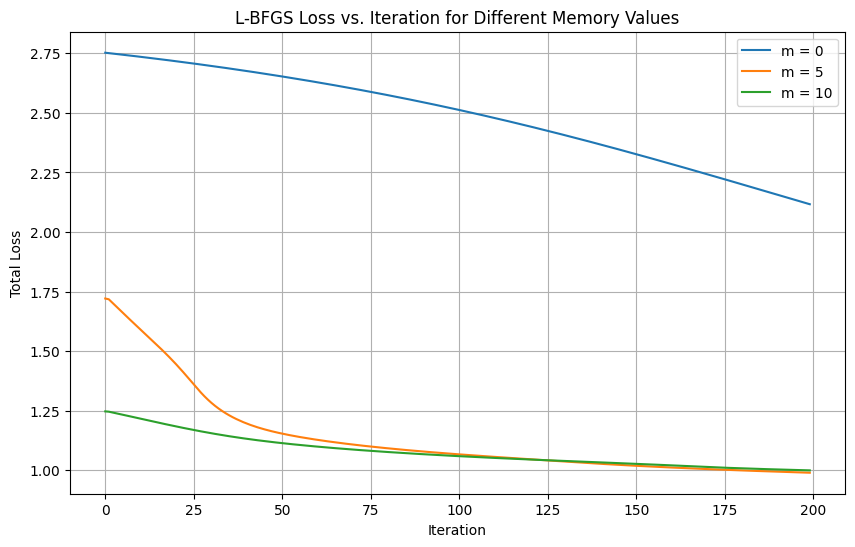

In [221]:
# L-BFGS Method

nb_iters = 200
alpha = 0.01
ms = [0, 5, 10]

losses_dict = {m: [] for m in ms}

for m in ms:
    x = torch.randn(A.size(1), device=device, requires_grad=True)
    memory = []
    for k in range(nb_iters):
        if k == 0:
            loss = f(x, A, y)
            loss.backward()
            g = x.grad.clone()
            x.grad.zero_()
            
            x_new = (x - alpha * g).detach().requires_grad_(True)
            f_new = f(x_new, A, y)
            f_new.backward()
            g_new = x_new.grad.clone()
            x_new.grad.zero_()
            
            s = x_new - x
            v = g_new - g
            memory.append((s.detach(), v.detach()))
            x = x_new
        
        else:
            loss = f(x, A, y)
            loss.backward()
            g = x.grad.clone()
            x.grad.zero_()
            
            q = g.clone()
            gammas = []
            
            for l in range(1, min(m, k) + 1):
                s, v = memory[-l]
                if torch.dot(s, v) > 0:
                    gamma = torch.dot(s, q) / torch.dot(v, s)
                    gammas.append(gamma)
                    q -= gamma * v
            
            gammas = gammas[::-1]
            
            for l in range(len(gammas)):
                s, v = memory[l]
                if torch.dot(s, v) > 0:
                    delta = torch.dot(v, q) / torch.dot(v, s)
                    q += (gammas[l] - delta) * s

            x_new = (x - alpha * q).detach().requires_grad_(True)
            f_new = f(x_new, A, y)
            f_new.backward()
            g_new = x_new.grad.clone()
            x_new.grad.zero_()

            s = x_new - x
            v = g_new - g
            
            if k >= m:
                memory.pop(0)
            memory.append((s.detach(), v.detach()))
            x = x_new

        losses_dict[m].append(loss.item())

        if k % 10 == 0 or k == nb_iters - 1:
            print(f"Iteration {k}/{nb_iters} : Loss : {loss}")

plt.figure(figsize=(10, 6))
for m, losses in losses_dict.items():
    plt.plot(range(nb_iters), losses, label=f"m = {m}")

plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.title("L-BFGS Loss vs. Iteration for Different Memory Values")
plt.legend()
plt.grid()
plt.show()

## Question 12

We compute the number of accesses to data points and updates at every iteration for the L-BFGS method with m=10.

In [230]:
# L-BFGS Method

nb_iters = 100
alpha = 0.01
ms = 10

x = torch.randn(A.size(1), device=device, requires_grad=True)
memory = []
data_access = 0
vector_updates = 0

for k in range(nb_iters):
    if k == 0:
        loss = f(x, A, y)
        data_access += 1
        loss.backward()
        g = x.grad.clone()
        x.grad.zero_()
        
        x_new = (x - alpha * g).detach().requires_grad_(True)
        f_new = f(x_new, A, y)
        data_access += 1
        f_new.backward()
        g_new = x_new.grad.clone()
        x_new.grad.zero_()
        
        s = x_new - x
        v = g_new - g
        memory.append((s.detach(), v.detach()))
        x = x_new
        vector_updates += 1
    
    else:
        loss = f(x, A, y)
        data_access += 1
        loss.backward()
        g = x.grad.clone()
        x.grad.zero_()
        
        q = g.clone()
        gammas = []
        
        if m > 0:
            for l in range(1, min(m, k) + 1):
                s, v = memory[-l]
                if torch.dot(s, v) > 0:
                    gamma = torch.dot(s, q) / torch.dot(v, s)
                    gammas.append(gamma)
                    q -= gamma * v
            
            gammas = gammas[::-1]
            
            for l in range(len(gammas)):
                s, v = memory[l]
                if torch.dot(s, v) > 0:
                    delta = torch.dot(v, q) / torch.dot(v, s)
                    q += (gammas[l] - delta) * s

        x_new = (x - alpha * q).detach().requires_grad_(True)
        f_new = f(x_new, A, y)
        data_access += 1
        f_new.backward()
        g_new = x_new.grad.clone()
        x_new.grad.zero_()

        s = x_new - x
        v = g_new - g
        
        if k >= m:
            memory.pop(0)
        memory.append((s.detach(), v.detach()))
        x = x_new
        vector_updates += 1


print("Data accesses:", data_access)
print("Vector updates:", vector_updates)

Data accesses: 200
Vector updates: 100


- For 100 iterations, the L-BFGS method has 200 Data accesses and 100 vector updates, while as previously seen, for the Adagrad Method with a batch size of 16 on 100 iterations the number of data accesses and vector updates is 6300. Again, the L-BFGS is much faster compared to the Adagrad method, and also more memory efficient but the adagrad method is more accurate and the loss is lower at the end.
- Therefore we have 1 vector update per iteration.